Class Distribution:
Benign: 15991
Highly dangerous: 5150
Moderately dangerous: 4190


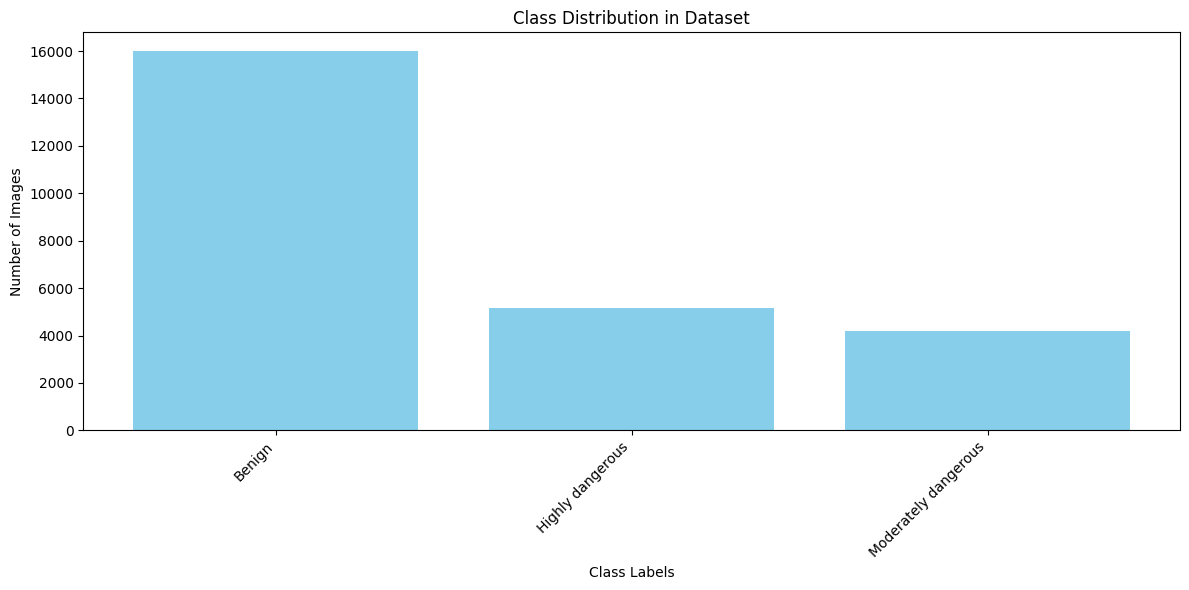


Class Ratios:
Benign: 63.13%
Highly dangerous: 20.33%
Moderately dangerous: 16.54%

No significantly imbalanced classes found.


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Function to analyze class distribution
def analyze_dataset(directory):
    """
    Analyze class distribution in an image dataset organized in subfolders.

    Args:
        directory (str): Path to the dataset root directory.

    Returns:
        dict: Class distribution with label names and image counts.
    """
    class_counts = {}
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):  # Ensure it's a directory
            num_images = len(os.listdir(subdir_path))
            class_counts[subdir] = num_images
    return class_counts

# Plot class distribution
def plot_class_distribution(class_counts):
    """
    Plot the class distribution.

    Args:
        class_counts (dict): Dictionary with class names as keys and counts as values.
    """
    labels = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(12, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Class Labels')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution in Dataset')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Main logic
dataset_dir = "./ISIC-Dataset-Raw/final-image-set-with-new-labels"  # Update this with your dataset directory path
class_counts = analyze_dataset(dataset_dir)

# Print the class distribution
print("Class Distribution:")
for label, count in class_counts.items():
    print(f"{label}: {count}")

# Plot the distribution
plot_class_distribution(class_counts)

# Check for imbalance
total_images = sum(class_counts.values())
class_ratios = {label: count / total_images for label, count in class_counts.items()}
print("\nClass Ratios:")
for label, ratio in class_ratios.items():
    print(f"{label}: {ratio:.2%}")

# Highlight Imbalanced Classes
threshold = 0.05  # Classes with less than 5% of total images are considered imbalanced
imbalanced_classes = {label: count for label, count in class_counts.items() if class_ratios[label] < threshold}

if imbalanced_classes:
    print("\nImbalanced Classes (Less than 5% of the total images):")
    for label, count in imbalanced_classes.items():
        print(f"{label}: {count} ({class_ratios[label]:.2%})")
else:
    print("\nNo significantly imbalanced classes found.")

In [3]:
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
import shutil

def create_new_dataset_structure(original_dir, new_dir):
    """
    Creates a new dataset folder structure based on the original dataset structure.

    Args:
        original_dir (str): Path to the original dataset directory.
        new_dir (str): Path to the new dataset directory.
    """
    if os.path.exists(new_dir):
        shutil.rmtree(new_dir)  # Remove existing folder if it exists
    os.makedirs(new_dir)

    for class_name in os.listdir(original_dir):
        class_dir = os.path.join(original_dir, class_name)
        if os.path.isdir(class_dir):  # Only process directories
            os.makedirs(os.path.join(new_dir, class_name), exist_ok=True)

def oversample_to_new_dataset(original_dir, new_dir, target_class, target_size):
    """
    Oversample the target class and save the new dataset to a new folder.

    Args:
        original_dir (str): Path to the original dataset directory.
        new_dir (str): Path to the new dataset directory.
        target_class (str): Name of the target class to oversample.
        target_size (int): Desired number of images for the target class.
    """
    original_class_dir = os.path.join(original_dir, target_class)
    new_class_dir = os.path.join(new_dir, target_class)

    # Copy original images to the new folder
    for img_name in os.listdir(original_class_dir):
        shutil.copy(os.path.join(original_class_dir, img_name), new_class_dir)

    # Generate augmented images
    images = os.listdir(original_class_dir)
    current_size = len(images)

    if current_size >= target_size:
        print(f"Class '{target_class}' already has {current_size} images. No oversampling needed.")
        return

    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    while current_size < target_size:
        img_name = random.choice(images)
        img_path = os.path.join(original_class_dir, img_name)

        # Load and preprocess the image
        img = load_img(img_path)
        img_array = img_to_array(img)
        img_array = img_array.reshape((1, *img_array.shape))

        # Generate augmented images
        for batch in datagen.flow(img_array, batch_size=1, save_prefix="aug", save_format="jpeg"):
            aug_img_name = f"aug_{current_size}.jpeg"
            save_img(os.path.join(new_class_dir, aug_img_name), batch[0])
            current_size += 1
            if current_size >= target_size:
                break

    print(f"Class '{target_class}' oversampled to {target_size} images in the new dataset.")

# Paths
original_dataset_dir = "./ISIC-Dataset-Raw/final-image-set-with-new-labels"  # Path to the original dataset
new_dataset_dir = "./ISIC-Dataset-Raw/final-image-set-with-new-labels-balanced"  # Path to save the new dataset
target_classes = {
    "Highly dangerous": 15991,  # Target size for oversampling
    "Moderately dangerous": 15991  # Target size for oversampling
}

# Create new dataset folder structure
create_new_dataset_structure(original_dataset_dir, new_dataset_dir)

# Perform oversampling for each target class
for class_name, target_size in target_classes.items():
    oversample_to_new_dataset(original_dataset_dir, new_dataset_dir, class_name, target_size)

print("New dataset with oversampled classes saved to:", new_dataset_dir)

Class 'Highly dangerous' oversampled to 15991 images in the new dataset.
Class 'Moderately dangerous' oversampled to 15991 images in the new dataset.
New dataset with oversampled classes saved to: ./ISIC-Dataset-Raw/final-image-set-with-new-labels-balanced
